# Network Intrusion Detection System (NIDS)
## Training Pipeline using UNSW-NB15 Dataset

This notebook provides a complete end-to-end pipeline for:
1. Loading and exploring the UNSW-NB15 dataset
2. Preprocessing and feature engineering
3. Training multiple ML models
4. Evaluating and comparing model performance
5. Saving the best model for deployment

## Setup and Imports

In [1]:
# Standard libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data_loader import load_data, get_data_info, get_feature_stats
from utils.feature_engineering import FeatureEngineer
from detection.model_trainer import IDSModelTrainer
import config
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful!")
print(f"Working directory: {os.getcwd()}")

✓ All imports successful!
Working directory: D:\Network_IDS\notebooks


## Step 1: Prepare Dataset

### Dataset Information:
- **Name**: UNSW-NB15
- **Source**: University of New South Wales (UNSW)
- **Size**: ~2.5 million records
- **Features**: 49 features
- **Attack Types**: 9 types (Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, Worms)



In [2]:
# Check if dataset exists
if not os.path.exists(config.TRAIN_FILE):
    print("⚠️  Dataset not found!")
    print(f"Please download and place files in: {config.RAW_DATA_DIR}")
else:
    print("✓ Dataset found!")
    print(f"Training file: {config.TRAIN_FILE}")
    print(f"Testing file: {config.TEST_FILE}")

✓ Dataset found!
Training file: D:/network_ids\data\raw\UNSW_NB15_training-set.csv
Testing file: D:/network_ids\data\raw\UNSW_NB15_testing-set.csv


## Step 2: Load and Explore Data

In [3]:
# Load training data
# Set sample_size=None to load full dataset
print("Loading training data...")
train_df = load_data(train=True, sample_size=0)

if train_df is not None:
    print("\n✓ Data loaded successfully!")
    get_data_info(train_df)

Loading training data...
Loading training data from D:/network_ids\data\raw\UNSW_NB15_training-set.csv...
Loaded 175341 samples with 45 features

✓ Data loaded successfully!

DATASET INFORMATION

Shape: (175341, 45)
Features: 45
Samples: 175341

--- Class Distribution ---
Normal (0): 56000 (31.94%)
Attack (1): 119341 (68.06%)

--- Attack Types Distribution ---
Normal: 56000 (31.94%)
Generic: 40000 (22.81%)
Exploits: 33393 (19.04%)
Fuzzers: 18184 (10.37%)
DoS: 12264 (6.99%)
Reconnaissance: 10491 (5.98%)
Analysis: 2000 (1.14%)
Backdoor: 1746 (1.00%)
Shellcode: 1133 (0.65%)
Worms: 130 (0.07%)

--- Data Types ---
int64      30
float64    11
object      4
Name: count, dtype: int64

--- Missing Values ---
No missing values found!

--- Sample Data ---
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3

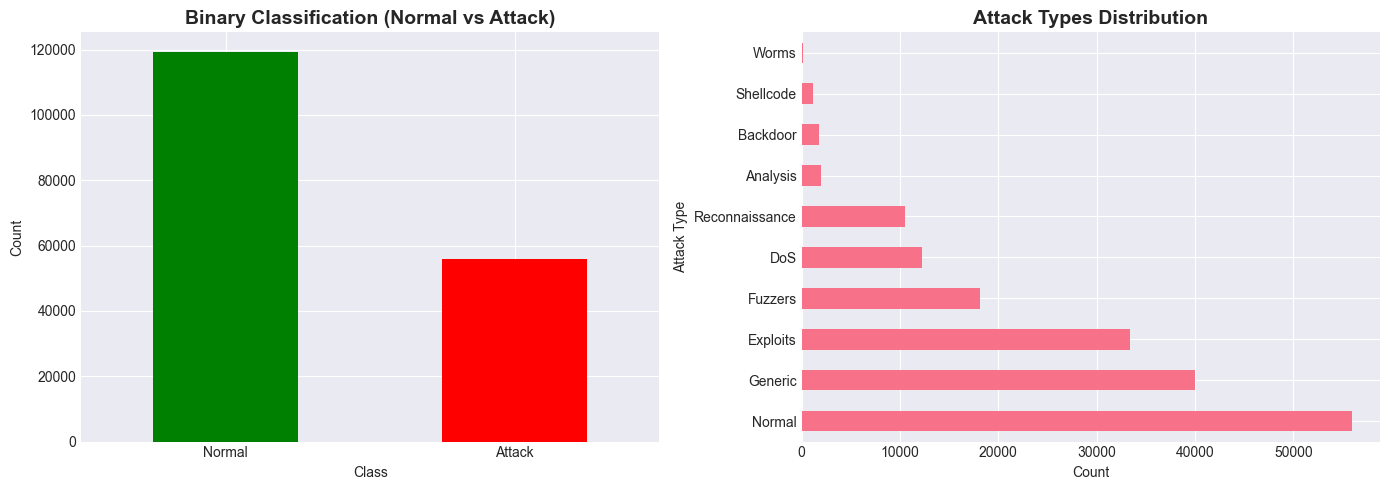


Class Balance:
Normal: 56000 (31.94%)
Attack: 119341 (68.06%)


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary classification
train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Binary Classification (Normal vs Attack)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal', 'Attack'], rotation=0)

# Attack types
if 'attack_cat' in train_df.columns:
    attack_counts = train_df['attack_cat'].value_counts()
    attack_counts.plot(kind='barh', ax=axes[1])
    axes[1].set_title('Attack Types Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Attack Type')

plt.tight_layout()
plt.show()

# Print statistics
normal_count = (train_df['label'] == 0).sum()
attack_count = (train_df['label'] == 1).sum()
print(f"\nClass Balance:")
print(f"Normal: {normal_count} ({normal_count/len(train_df)*100:.2f}%)")
print(f"Attack: {attack_count} ({attack_count/len(train_df)*100:.2f}%)")

## Step 3: Feature Engineering

We'll perform:
1. Handle missing values
2. Encode categorical features
3. Scale numerical features
4. Optional: Feature selection

In [5]:
# Initialize feature engineer
feature_engineer = FeatureEngineer()

# Preprocess training data
X_train_full, y_train_full = feature_engineer.preprocess(
    train_df, 
    fit=True,
    select_features=True,
    k_features=30
)

print(f"\n✓ Feature engineering complete!")
print(f"Features shape: {X_train_full.shape}")
print(f"Labels shape: {y_train_full.shape}")


PREPROCESSING PIPELINE

1. Handling missing values...
2. Removing infinite values...
3. Encoding categorical features...
Encoding 3 categorical features...
4. Scaling features...
Scaling 42 numerical features...
5. Selecting features...
Selecting top 30 features...
Selected features: ['dur', 'state', 'spkts', 'dpkts', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'dloss', 'sinpkt', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']

Preprocessing complete!
Final shape: (175341, 30)


✓ Feature engineering complete!
Features shape: (175341, 30)
Labels shape: (175341,)


In [6]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=config.RANDOM_STATE,
    stratify=y_train_full
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nValidation set class distribution:")
print(y_val.value_counts())

Training set: (140272, 30)
Validation set: (35069, 30)

Validation set class distribution:
label
1    23869
0    11200
Name: count, dtype: int64


## Step 4: Train Machine Learning Models

We'll train and compare multiple models:
1. **Random Forest** - Ensemble of decision trees
2. **Gradient Boosting** - Sequential ensemble method
3. **Multi-Layer Perceptron** - Neural network
4. **Isolation Forest** - Unsupervised anomaly detection

### 4.1 Random Forest Classifier

In [7]:
# Train Random Forest
print("Training Random Forest Classifier...\n")
rf_trainer = IDSModelTrainer(model_type='random_forest')
rf_history = rf_trainer.train(X_train, y_train, X_val, y_val)

# Get feature importance
feature_importance = rf_trainer.get_feature_importance(
    feature_names=X_train.columns.tolist(),
    top_k=15
)

Training Random Forest Classifier...


TRAINING RANDOM_FOREST MODEL
Training on 140272 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



--- Training Set Evaluation ---


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


Accuracy:  0.9787
Precision: 0.9772
Recall:    0.9918
F1-Score:  0.9844
ROC-AUC:   0.9983

Confusion Matrix:
[[42591  2209]
 [  785 94687]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97     44800
      Attack       0.98      0.99      0.98     95472

    accuracy                           0.98    140272
   macro avg       0.98      0.97      0.98    140272
weighted avg       0.98      0.98      0.98    140272


Attack Detection Rate: 0.9918 (94687/95472)
False Alarm Rate: 0.0493 (2209/44800)

--- Validation Set Evaluation ---


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Accuracy:  0.9544
Precision: 0.9574
Recall:    0.9765
F1-Score:  0.9669
ROC-AUC:   0.9923

Confusion Matrix:
[[10163  1037]
 [  561 23308]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.91      0.93     11200
      Attack       0.96      0.98      0.97     23869

    accuracy                           0.95     35069
   macro avg       0.95      0.94      0.95     35069
weighted avg       0.95      0.95      0.95     35069


Attack Detection Rate: 0.9765 (23308/23869)
False Alarm Rate: 0.0926 (1037/11200)

Training completed in 14.55 seconds


Top 15 Most Important Features:
           feature  importance
6             sttl    0.209162
22    ct_state_ttl    0.119072
9            dload    0.073011
7             dttl    0.057033
8            sload    0.049637
19          ackdat    0.045359
3            dpkts    0.042500
0              dur    0.036017
5             rate    0.034850
20           dmean    0.033604
28      ct_srv

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


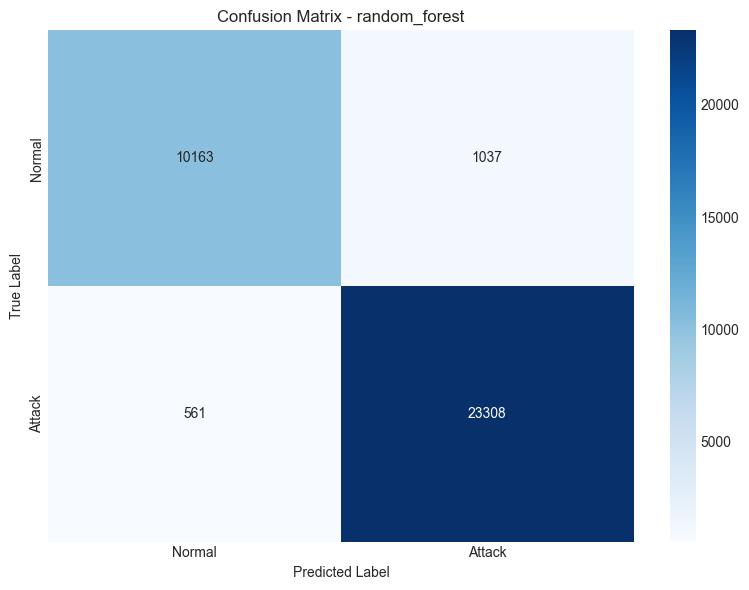

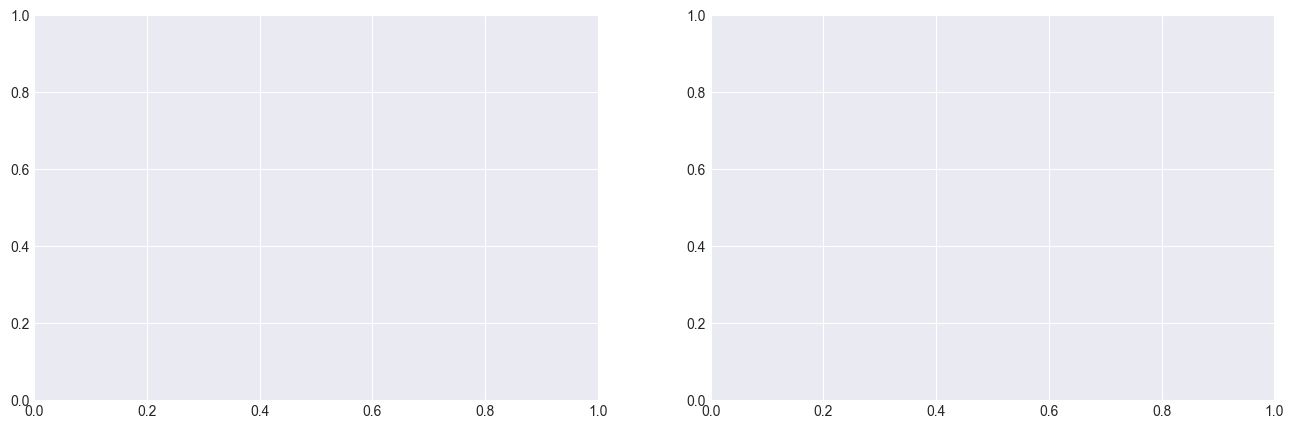

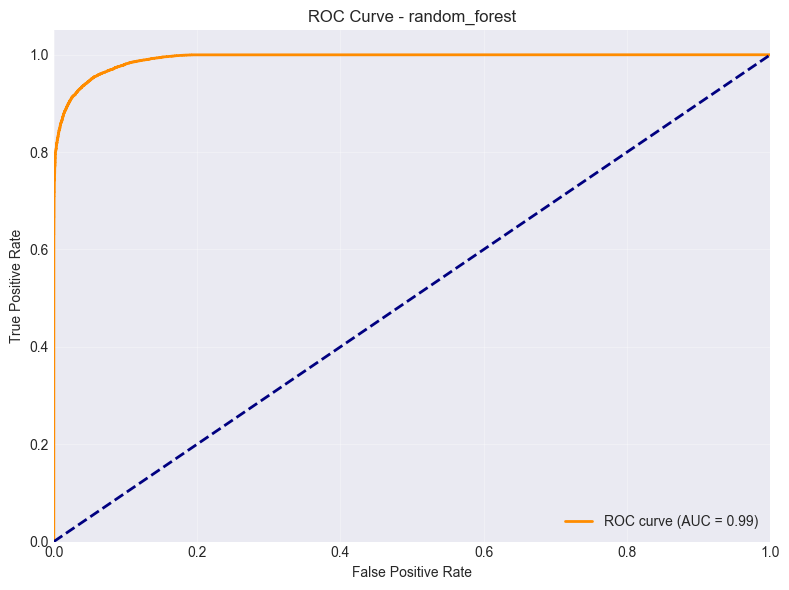

In [8]:
# Visualize Random Forest performance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Confusion Matrix
plt.sca(axes[0])
rf_trainer.plot_confusion_matrix(X_val, y_val)

# ROC Curve
plt.sca(axes[1])
rf_trainer.plot_roc_curve(X_val, y_val)

plt.tight_layout()
plt.show()

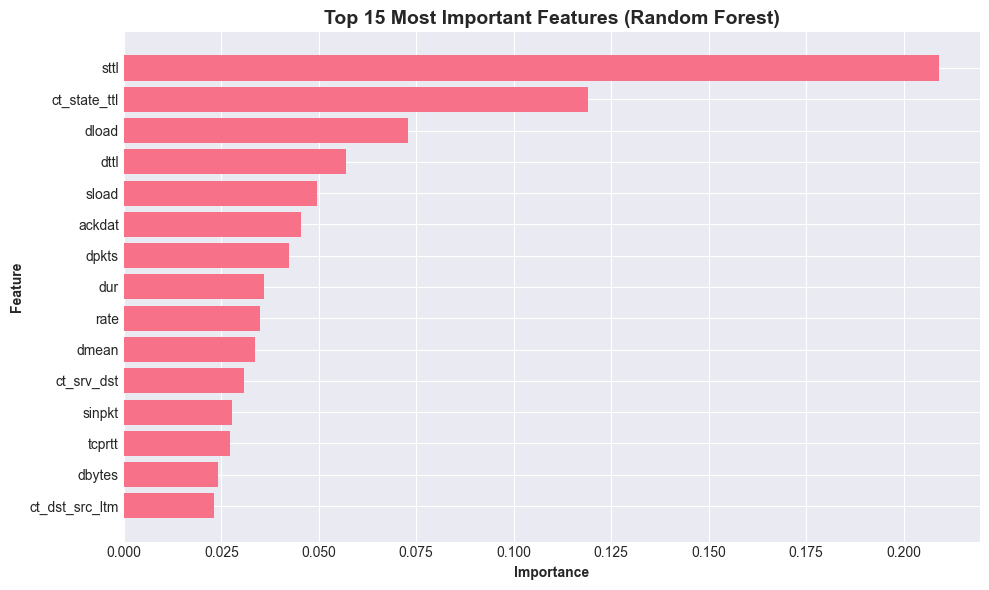

In [9]:
# Visualize feature importance
if feature_importance is not None:
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.ylabel('Feature', fontweight='bold')
    plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 4.2 Gradient Boosting Classifier

In [10]:
# Train Gradient Boosting
print("Training Gradient Boosting Classifier...\n")
gb_trainer = IDSModelTrainer(model_type='gradient_boosting')
gb_history = gb_trainer.train(X_train, y_train, X_val, y_val)

Training Gradient Boosting Classifier...


TRAINING GRADIENT_BOOSTING MODEL
Training on 140272 samples...
      Iter       Train Loss   Remaining Time 
         1           1.1036            3.45m
         2           0.9865            3.12m
         3           0.8925            2.81m
         4           0.8131            2.64m
         5           0.7464            2.51m
         6           0.6909            2.41m
         7           0.6430            2.34m
         8           0.5998            2.32m
         9           0.5620            2.32m
        10           0.5292            2.34m
        20           0.3506            1.98m
        30           0.2887            1.72m
        40           0.2624            1.48m
        50           0.2473            1.32m
        60           0.2388            1.07m
        70           0.2323           48.28s
        80           0.2281           32.33s
        90           0.2241           16.63s
       100           0.2207           

### 4.3 Multi-Layer Perceptron (Neural Network)

In [11]:
# Train MLP
print("Training Multi-Layer Perceptron...\n")
mlp_trainer = IDSModelTrainer(model_type='mlp')
mlp_history = mlp_trainer.train(X_train, y_train, X_val, y_val)

Training Multi-Layer Perceptron...


TRAINING MLP MODEL
Training on 140272 samples...
Iteration 1, loss = 0.17648771
Validation score: 0.936270
Iteration 2, loss = 0.13538227
Validation score: 0.940334
Iteration 3, loss = 0.13092436
Validation score: 0.939264
Iteration 4, loss = 0.12746466
Validation score: 0.939549
Iteration 5, loss = 0.12561427
Validation score: 0.940476
Iteration 6, loss = 0.12410146
Validation score: 0.940619
Iteration 7, loss = 0.12230537
Validation score: 0.942615
Iteration 8, loss = 0.12128432
Validation score: 0.939264
Iteration 9, loss = 0.12021739
Validation score: 0.944040
Iteration 10, loss = 0.11856736
Validation score: 0.943755
Iteration 11, loss = 0.11786584
Validation score: 0.942757
Iteration 12, loss = 0.11662080
Validation score: 0.941902
Iteration 13, loss = 0.11569093
Validation score: 0.944825
Iteration 14, loss = 0.11517694
Validation score: 0.942900
Iteration 15, loss = 0.11446160
Validation score: 0.942472
Iteration 16, loss = 0.11379614
Valida

### 4.4 Isolation Forest (Unsupervised Anomaly Detection)

In [12]:
# Train Isolation Forest
print("Training Isolation Forest...\n")
if_trainer = IDSModelTrainer(model_type='isolation_forest')
if_history = if_trainer.train(X_train, y_train, X_val, y_val)

Training Isolation Forest...


TRAINING ISOLATION_FOREST MODEL
Training on 44800 normal samples...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished



--- Training Set Evaluation ---


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


Accuracy:  0.5951
Precision: 0.9060
Recall:    0.4520
F1-Score:  0.6031
ROC-AUC:   0.1527

Confusion Matrix:
[[40320  4480]
 [52315 43157]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.44      0.90      0.59     44800
      Attack       0.91      0.45      0.60     95472

    accuracy                           0.60    140272
   macro avg       0.67      0.68      0.59    140272
weighted avg       0.76      0.60      0.60    140272


Attack Detection Rate: 0.4520 (43157/95472)
False Alarm Rate: 0.1000 (4480/44800)

--- Validation Set Evaluation ---


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Accuracy:  0.5941
Precision: 0.9074
Recall:    0.4495
F1-Score:  0.6012
ROC-AUC:   0.1515

Confusion Matrix:
[[10105  1095]
 [13139 10730]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.43      0.90      0.59     11200
      Attack       0.91      0.45      0.60     23869

    accuracy                           0.59     35069
   macro avg       0.67      0.68      0.59     35069
weighted avg       0.76      0.59      0.60     35069


Attack Detection Rate: 0.4495 (10730/23869)
False Alarm Rate: 0.0978 (1095/11200)

Training completed in 1.75 seconds



## Step 5: Model Comparison

In [13]:
# Compare all models
comparison_data = {
    'Random Forest': rf_history['val_metrics'],
    'Gradient Boosting': gb_history['val_metrics'],
    'MLP': mlp_history['val_metrics'],
    'Isolation Forest': if_history['val_metrics']
}

# Create comparison DataFrame
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score', 'attack_detection_rate', 'false_alarm_rate']

comparison_df = pd.DataFrame({
    model: {metric: comparison_data[model][metric] for metric in metrics_to_compare}
    for model in comparison_data.keys()
}).T

print("\n" + "="*80)
print("MODEL COMPARISON (Validation Set)")
print("="*80)
print(comparison_df.round(4))
print("="*80)


MODEL COMPARISON (Validation Set)
                   accuracy  precision  recall  f1_score  \
Random Forest        0.9544     0.9574  0.9765    0.9669   
Gradient Boosting    0.9487     0.9514  0.9744    0.9628   
MLP                  0.9465     0.9518  0.9705    0.9611   
Isolation Forest     0.5941     0.9074  0.4495    0.6012   

                   attack_detection_rate  false_alarm_rate  
Random Forest                     0.9765            0.0926  
Gradient Boosting                 0.9744            0.1061  
MLP                               0.9705            0.1046  
Isolation Forest                  0.4495            0.0978  


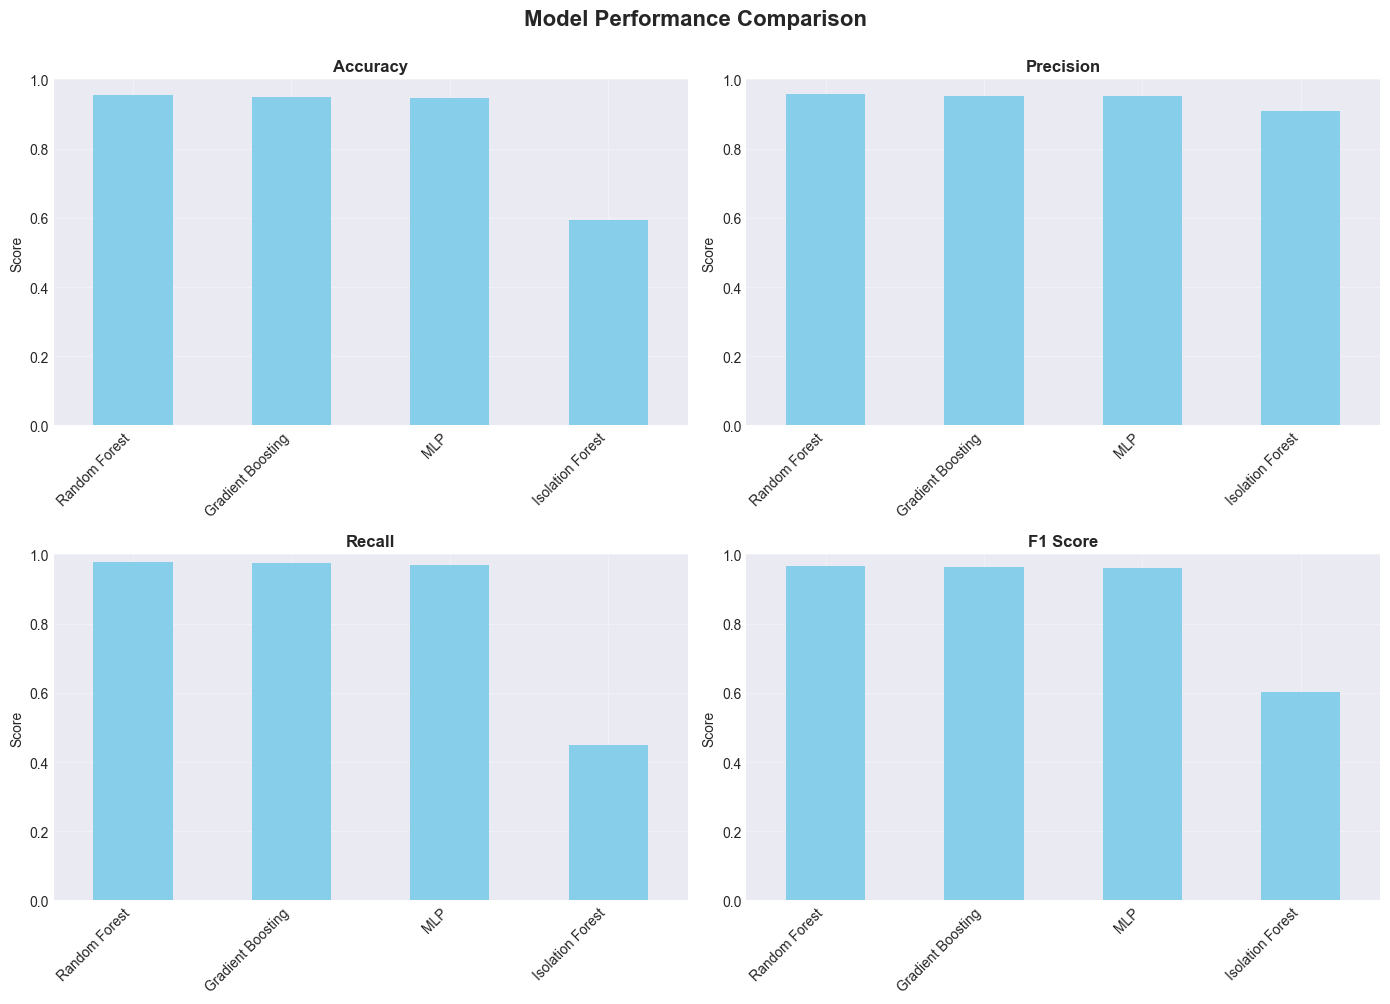

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Step 6: Test on Test Set

In [15]:
# Load test data
print("Loading test data...")
test_df = load_data(train=False, sample_size=0)

if test_df is not None:
    X_test, y_test = feature_engineer.preprocess(
        test_df,
        fit=False,
        select_features=True
    )
    
    print(f"\n✓ Test data preprocessed!")
    print(f"Test set shape: {X_test.shape}")

Loading test data...
Loading testing data from D:/network_ids\data\raw\UNSW_NB15_testing-set.csv...
Loaded 82332 samples with 45 features

PREPROCESSING PIPELINE

1. Handling missing values...
2. Removing infinite values...
3. Encoding categorical features...
Encoding 3 categorical features...
4. Scaling features...
Scaling 42 numerical features...
5. Selecting features...

Preprocessing complete!
Final shape: (82332, 30)


✓ Test data preprocessed!
Test set shape: (82332, 30)


In [16]:
# Evaluate best model on test set 
print("Evaluating Random Forest on test set...")
test_metrics = rf_trainer.evaluate(X_test, y_test, dataset_name="Test")

Evaluating Random Forest on test set...

--- Test Set Evaluation ---


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy:  0.8621
Precision: 0.8063
Recall:    0.9864
F1-Score:  0.8873
ROC-AUC:   0.9723

Confusion Matrix:
[[26260 10740]
 [  615 44717]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.71      0.82     37000
      Attack       0.81      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.85     82332
weighted avg       0.88      0.86      0.86     82332


Attack Detection Rate: 0.9864 (44717/45332)
False Alarm Rate: 0.2903 (10740/37000)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


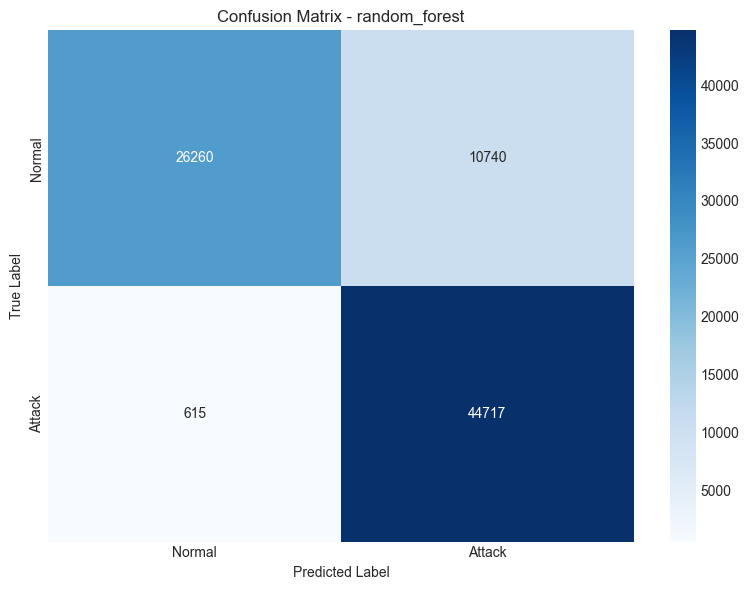

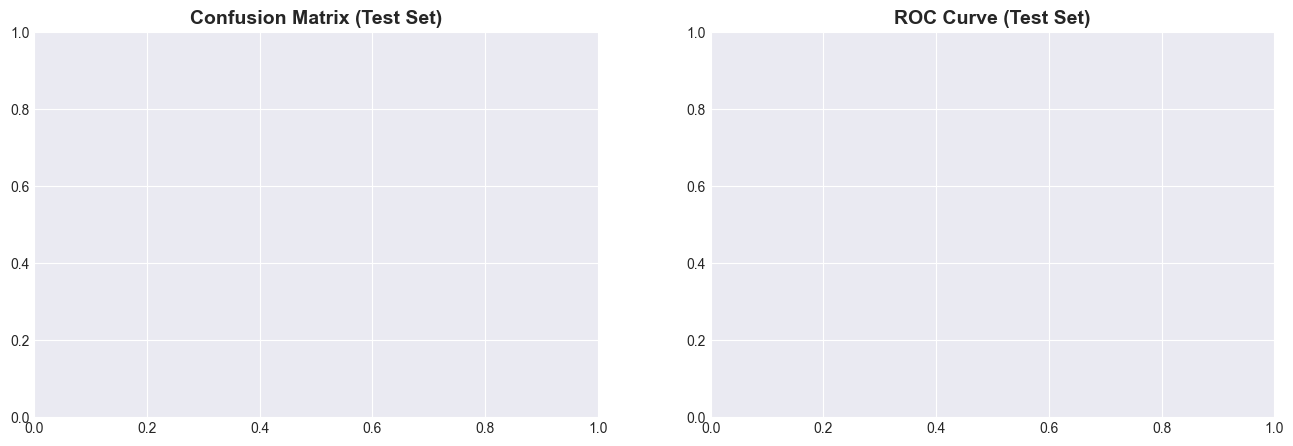

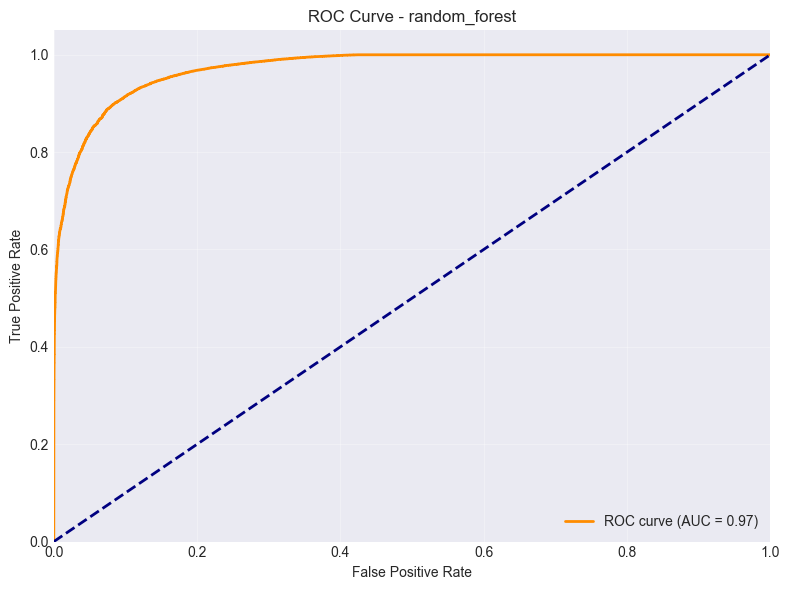

In [17]:
# Final visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plt.sca(axes[0])
rf_trainer.plot_confusion_matrix(X_test, y_test)
axes[0].set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

plt.sca(axes[1])
rf_trainer.plot_roc_curve(X_test, y_test)
axes[1].set_title('ROC Curve (Test Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Step 7: Save Model and Artifacts

In [18]:
# Save feature engineering pipeline
feature_engineer.save()

# Save the best model
rf_trainer.save_model()

print("\n✓ Model and artifacts saved successfully!")
print(f"Model saved to: {config.MODEL_DIR}")
print(f"Scaler saved to: {config.SCALER_PATH}")

Feature engineering pipeline saved to D:/network_ids\models\scaler.pkl
Model saved to D:/network_ids\models\ids_model_random_forest.pkl

✓ Model and artifacts saved successfully!
Model saved to: D:/network_ids\models
Scaler saved to: D:/network_ids\models\scaler.pkl


## Step 8: Model Summary and Next Steps

In [19]:
print("\n" + "="*80)
print("TRAINING COMPLETE - MODEL SUMMARY")
print("="*80)
print(f"\nBest Model: Random Forest")
print(f"Training Time: {rf_history['training_time']:.2f} seconds")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
print(f"  Attack Detection Rate: {test_metrics['attack_detection_rate']:.4f}")
print(f"  False Alarm Rate: {test_metrics['false_alarm_rate']:.4f}")
print("\n" + "="*80)


TRAINING COMPLETE - MODEL SUMMARY

Best Model: Random Forest
Training Time: 14.55 seconds

Test Set Performance:
  Accuracy:  0.8621
  Precision: 0.8063
  Recall:    0.9864
  F1-Score:  0.8873
  Attack Detection Rate: 0.9864
  False Alarm Rate: 0.2903

